In [2]:
# !pip install --upgrade transformers

# prepare dataset

In [12]:
from sahi.slicing import slice_image
from glob import glob

In [13]:
for filename in glob('train/images/*')[:-1]:

    idx = filename.split('\\')[-1].split('_')[-1].split('.')[0]

    _ = slice_image(
        f'train/images/train_image_{idx}.png',
        output_file_name=idx,
        output_dir='data/train/images',
        slice_height=512,
        slice_width=512,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
    )
    
    _ = slice_image(
        f'train/masks/train_mask_{idx}.png',
        output_file_name=idx,
        output_dir='data/train/mask',
        slice_height=512,
        slice_width=512,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
    )

In [14]:
for filename in glob('train/images/*')[-1:]:

    idx = filename.split('\\')[-1].split('_')[-1].split('.')[0]

    _ = slice_image(
        f'train/images/train_image_{idx}.png',
        output_file_name=idx,
        output_dir='data/test/images',
        slice_height=512,
        slice_width=512,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
    )
    
    _ = slice_image(
        f'train/masks/train_mask_{idx}.png',
        output_file_name=idx,
        output_dir='data/test/mask',
        slice_height=512,
        slice_width=512,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
    )

# segformer

In [21]:
# !pip install albumentations -U --user

In [1]:
!nvidia-smi

Fri Nov 24 12:05:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
|  0%   47C    P8    34W / 450W |    704MiB / 24564MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug

C:\Users\SVA\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
D:\anaconda3\envs\cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
WIDTH = 512
HEIGHT = 512

In [4]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "mask")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)

#         image = Image.open()
#         segmentation_map = Image.open()

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [5]:
transform = aug.Compose([
    aug.Flip(p=0.5)
])

In [6]:
root_dir = 'data'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

D:\anaconda3\envs\cv\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 4979
Number of validation examples: 144


In [8]:
encoded_inputs = train_dataset[3]

In [9]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [10]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [11]:
encoded_inputs["labels"].sum()

tensor(3063)

In [12]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1])

In [13]:
mask = encoded_inputs["labels"].numpy()

In [14]:
import matplotlib.pyplot as plt

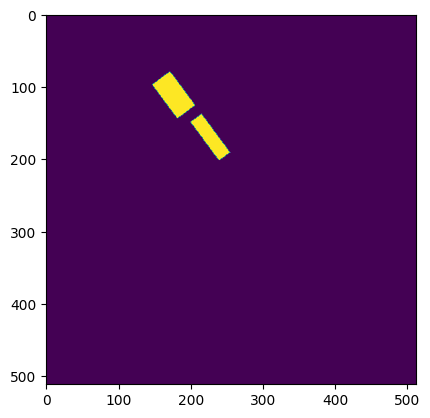

In [15]:
plt.imshow(mask)

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

In [17]:
batch = next(iter(train_dataloader))

In [18]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([8, 3, 512, 512])
labels torch.Size([8, 512, 512])


In [19]:
batch["labels"].shape

torch.Size([8, 512, 512])

In [20]:
# # classes = pd.read_csv('class_dict_seg.csv')['name']
# id2label = {1: 'building'}
# label2id = {v: k for k, v in id2label.items()}

In [21]:
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
#                                                          num_labels=len(id2label), id2label=id2label, label2id=label2id,
#                                                          reshape_last_stage=True)

In [22]:
# optimizer = AdamW(model.parameters(), lr=0.00006)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print("Model Initialized!")

In [23]:
# for epoch in range(1, 11):  # loop over the dataset multiple times
#     print("Epoch:", epoch)
#     pbar = tqdm(train_dataloader)
#     accuracies = []
#     losses = []
#     val_accuracies = []
#     val_losses = []
#     model.train()
#     for idx, batch in enumerate(pbar):
#         # get the inputs;
#         pixel_values = batch["pixel_values"].to(device)
#         labels = batch["labels"].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward
#         outputs = model(pixel_values=pixel_values, labels=labels)

#         # evaluate
#         upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
#         predicted = upsampled_logits.argmax(dim=1)

#         mask = (labels != 255) # we don't include the background class in the accuracy calculation
#         pred_labels = predicted[mask].detach().cpu().numpy()
#         true_labels = labels[mask].detach().cpu().numpy()
#         accuracy = accuracy_score(pred_labels, true_labels)
#         loss = outputs.loss
#         accuracies.append(accuracy)
#         losses.append(loss.item())
#         pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

#         # backward + optimize
#         loss.backward()
#         optimizer.step()
#     else:
#         model.eval()
#         with torch.no_grad():
#             for idx, batch in enumerate(valid_dataloader):
#                 pixel_values = batch["pixel_values"].to(device)
#                 labels = batch["labels"].to(device)

#                 outputs = model(pixel_values=pixel_values, labels=labels)
#                 upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
#                 predicted = upsampled_logits.argmax(dim=1)

#                 mask = (labels != 255) # we don't include the background class in the accuracy calculation
#                 pred_labels = predicted[mask].detach().cpu().numpy()
#                 true_labels = labels[mask].detach().cpu().numpy()
#                 accuracy = accuracy_score(pred_labels, true_labels)
#                 val_loss = outputs.loss
#                 val_accuracies.append(accuracy)
#                 val_losses.append(val_loss.item())

#     print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
#          Train Loss: {sum(losses)/len(losses)}\
#          Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
#          Val Loss: {sum(val_losses)/len(val_losses)}")

In [24]:
# Load the pre-trained model
model = SegformerForSemanticSegmentation.from_pretrained(
    # 'ratnaonline1/segFormer-b4-city-satellite-segmentation-1024x1024',
                                                         'nvidia/segformer-b2-finetuned-ade-512-512',
                                                         # ignore_mismatched_sizes=True,
                                                         # reshape_last_stage=True
                                                        )
 
# Adjust the number of classes for BDD dataset
model.config.num_labels = 2  # Replace with the actual number of classes

In [25]:
# Check for CUDA acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [26]:
def mean_iou(preds, labels, num_classes):
    # Flatten predictions and labels
    preds_flat = preds.view(-1)
    labels_flat = labels.view(-1)
 
    # Check that the number of elements in the flattened predictions
    # and labels are equal
    if preds_flat.shape[0] != labels_flat.shape[0]:
        raise ValueError(f"Predictions and labels have mismatched shapes: "
                         f"{preds_flat.shape} vs {labels_flat.shape}")
 
    # Calculate the Jaccard score for each class
    iou = jaccard_score(labels_flat.cpu().numpy(), preds_flat.cpu().numpy(),
                        average=None, labels=range(num_classes))
 
    # Return the mean IoU
    return np.mean(iou)

In [27]:
from transformers import get_scheduler
import copy
from sklearn.metrics import jaccard_score

In [28]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
 
# Define the learning rate scheduler
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
 
# Placeholder for best mean IoU and best model weights
best_iou = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

D:\anaconda3\envs\cv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
loss_all = []

for epoch in range(num_epochs):
    model.train()
    train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for i, batch in enumerate(train_iterator):
        # images, masks = batch
        # images = images.to(device)
        # masks = masks.to(device).long()  # Ensure masks are LongTensors

        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device).long()
 
        # Remove the channel dimension from the masks tensor
        labels = labels.squeeze(1)  # This changes the shape from [batch, 1, H, W] to [batch, H, W]
        optimizer.zero_grad()
 
        # Pass pixel_values and labels to the model
        outputs = model(pixel_values=pixel_values, labels=labels, return_dict=True)
         
        loss = outputs["loss"]
        loss.backward()
 
        optimizer.step()
        lr_scheduler.step()
        outputs = nn.functional.interpolate(outputs["logits"], size=labels.shape[-2:], mode="bilinear", align_corners=False)

        loss_all.append(loss.item())
        train_iterator.set_postfix(loss=np.mean(loss_all))

        # if i == 20:
        #     break

    # Evaluation loop for each epoch
    model.eval()
    total_iou = 0
    num_batches = 0
    valid_iterator = tqdm(valid_dataloader, desc="Validation", unit="batch")
    for batch in valid_iterator:
        # images, masks = batch
        # images = images.to(device)
        # masks = masks.to(device).long()

        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device).long()
     
        with torch.no_grad():
            # Get the logits from the model and apply argmax to get the predictions
            outputs = model(pixel_values=pixel_values, return_dict=True)
            outputs = nn.functional.interpolate(outputs["logits"], size=labels.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(outputs, dim=1)
            preds = torch.unsqueeze(preds, dim=1)
     
        preds = preds.view(-1)
        labels = labels.view(-1)
     
        # Compute IoU
        iou = mean_iou(preds, labels, model.config.num_labels)
        total_iou += iou
        num_batches += 1
        valid_iterator.set_postfix(mean_iou=iou)
     
    epoch_iou = total_iou / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} - Mean IoU: {epoch_iou:.4f}")
     
    # Check for improvement
    if epoch_iou > best_iou:
        print(f"Validation IoU improved from {best_iou:.4f} to {epoch_iou:.4f}")
        best_iou = epoch_iou
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, 'best_model.pth')

Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.61batch/s, mean_iou=0.538]


Epoch 1/10 - Mean IoU: 0.5451
Validation IoU improved from 0.0000 to 0.5451


Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.63batch/s, mean_iou=0.509]


Epoch 2/10 - Mean IoU: 0.5172


Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54batch/s, mean_iou=0.472]


Epoch 3/10 - Mean IoU: 0.4687


Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.73batch/s, mean_iou=0.472]


Epoch 4/10 - Mean IoU: 0.4698


Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.64batch/s, mean_iou=0.473]


Epoch 5/10 - Mean IoU: 0.4699


Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62batch/s, mean_iou=0.472]


Epoch 6/10 - Mean IoU: 0.4698


Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.64batch/s, mean_iou=0.472]


Epoch 7/10 - Mean IoU: 0.4698


Validation: 100%|███████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.63batch/s, mean_iou=0.472]


Epoch 8/10 - Mean IoU: 0.4698


Epoch 9/10:  15%|████████▏                                             | 95/623 [01:06<06:10,  1.43batch/s, loss=0.199]


KeyboardInterrupt: 

# Hugging Face Inference 🤗

In [30]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import math

In [31]:
# # classes = pd.read_csv('class_dict_seg.csv')['name']
# id2label = {1: 'building'}
# label2id = {v: k for k, v in id2label.items()}

In [32]:
# root_dir = 'data'
# feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
#                                                          num_labels=len(id2label), id2label=id2label, label2id=label2id,
#                                                          reshape_last_stage=True)
# model = model.to(device)

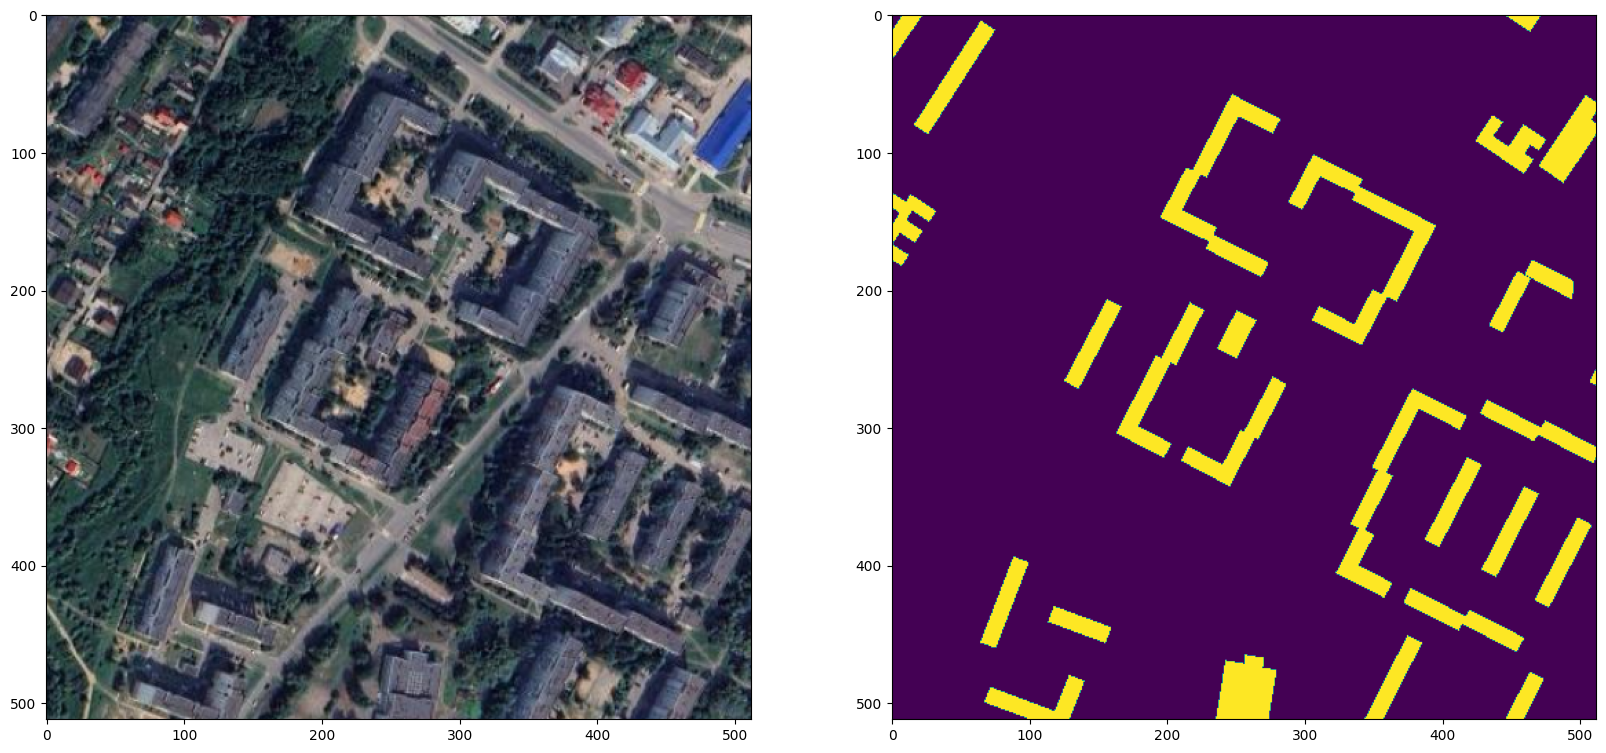

In [33]:
image = cv2.imread('data/test/images/020_0_2870_512_3382.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread('data/test/mask/020_0_2870_512_3382.png', 0)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [34]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


D:\anaconda3\envs\cv\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [35]:
with torch.no_grad():
    outputs = model(pixel_values=pixel_values, return_dict=True)
    outputs = nn.functional.interpolate(outputs["logits"], size=image.shape[:-1], mode='bilinear', align_corners=False)
    preds = torch.argmax(outputs, dim=1)
    preds = torch.unsqueeze(preds, dim=1)
    predicted_mask = (torch.sigmoid(preds) > 0.5).float()

In [36]:
torch.sigmoid(preds).max()

tensor(0.7311, device='cuda:0')

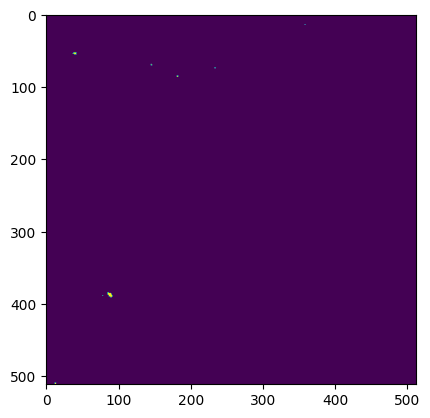

In [37]:
plt.imshow(predicted_mask.detach().cpu().numpy()[0, 0, ...])

In [54]:
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    print(logits.shape)

torch.Size([1, 1, 128, 128])


In [58]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

NameError: name 'color' is not defined

In [ ]:
img.shape

(2000, 2000, 3)

In [ ]:
def crop_augment(img):
    HEIGHT, WIDTH = 2000, 2000

    vertical = math.ceil(img.shape[0] / HEIGHT)
    horizontal = math.ceil(img.shape[1] / WIDTH)
    start_v = 0
    count = 1
    data = {'images': [],
            'horizontal': horizontal,
            'vertical': vertical}
    for v in range(vertical):
        start_h = 0
        for h in range(horizontal):
            if start_h + WIDTH > img.shape[1]:
                start_h = start_h - ((start_h + WIDTH) - img.shape[1])
            if start_v + HEIGHT > img.shape[0]:
                start_v = start_v - ((start_v + HEIGHT) - img.shape[0])
            crop = img[start_v:start_v+HEIGHT, start_h:start_h+WIDTH]
            data['images'].append(crop)
            count += 1
            start_h += WIDTH
        start_v += HEIGHT

    return data

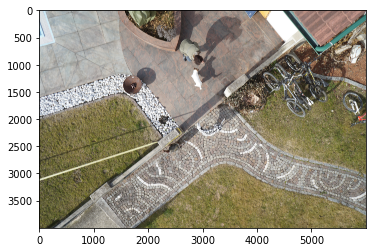

In [ ]:
image = cv2.imread('532.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

data = crop_augment(image)
plt.imshow(image)

In [ ]:
df = pd.read_csv('drone_dataset/class_dict_seg.csv')
classes = df['name']
palette = df[[' r', ' g', ' b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
root_dir = 'drone_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cpu")
model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)
model = model.to(device)

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
images = []
for img in data['images']:
    pixel_values = feature_extractor_inference(img, return_tensors="pt").pixel_values[0].numpy()
    images.append(pixel_values)
pixel_values = torch.tensor(np.array(images)).to(device)
print(pixel_values.shape)

torch.Size([6, 3, 512, 512])


In [ ]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)